In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

/home/juliana/miniconda3/envs/pytevec/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Functions

def consitency_mod(metric, col,n_neighbors=5):
    #Function to calculate consistency
    X = metric.dataset.features
    X = np.delete(X, col, 1)
    X = StandardScaler().fit_transform(X) 
    num_samples = X.shape[0]
    y = metric.dataset.labels

    # learn a KNN on the features
    nbrs = NearestNeighbors(n_neighbors, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)

    # compute consistency score
    consistency = 0.0
    for i in range(num_samples):
        consistency += np.abs(y[i] - np.mean(y[indices[i]]))
    consistency = 1.0 - consistency/num_samples

    return consistency

## Loading data

In [3]:
path = ''
df_original = pd.read_excel(path + 'data/default of credit card clients.xls', header=1)
df_original.columns = ['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 
                       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
                       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 
                       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4',
                       'pay_amt5', 'pay_amt6', 'payment_next_month']
df_original.drop('id', axis=1, inplace=True)
print(df_original.shape)
df_original.head()

(30000, 24)


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Preprocessing

In [4]:
df_proces = df_original.copy()

df_proces.loc[df_proces['marriage'] == 0, 'marriage'] = 3
df_proces.loc[df_proces['education'].isin([0, 5, 6]), 'education'] = 4
df_proces['sex'] = df_proces['sex'].apply(lambda row: 0 if row == 2 else 1)

columns_cat = ['education', 'marriage']

lb_encoder = LabelEncoder()
for col_cat in columns_cat:  
    df_proces[col_cat] = lb_encoder.fit_transform(df_proces[col_cat])

df_proces = df_proces.astype(float)
df_proces.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,payment_next_month
0,20000.0,0.0,1.0,0.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,0.0,1.0,1.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,90000.0,0.0,1.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,50000.0,0.0,1.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,50000.0,1.0,1.0,0.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


In [5]:
for col_cat in columns_cat:  
    one_hot = OneHotEncoder(sparse=False)
    res = one_hot.fit_transform(df_proces[[col_cat]])
    num_col = res.shape[1]
    for idx in range(num_col):
        df_proces['{}_{}'.format(col_cat, idx)] = res[:, idx]
        
df_proces.drop(columns_cat, axis=1, inplace=True)
df_proces.head()

,limit_bal,sex,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,payment_next_month,education_0,education_1,education_2,education_3,marriage_0,marriage_1,marriage_2
0,20000.0,0.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,120000.0,0.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,90000.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,50000.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,50000.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
metadata = {'label_maps': [{0.0: 'no', 1.0: 'yes'}], 
            'protected_attribute_maps': [{0.0: 'female', 1.0: 'male'}]}
unprivileged_groups=[{'sex': [0.0]}]
privileged_groups=[{'sex': [1.0]}]
protected_attribute_names = ['sex']
label_names = ['payment_next_month']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 1

Disparate impact dados originais:  0.14031177319235133


In [0]:
lst_res = []

## Model with original data

In [0]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)   
X_train_orig = scale.transform(dataset_train.features)     
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)  
y_test = dataset_test.labels.ravel()

### Random Forest

In [9]:
model_orig_rf = RandomForestClassifier()
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
y_pred_test = model_orig_rf.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_rf.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_rf = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_rf = metric_orig_pred_rf.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_rf))
mean_difference_orig_pred_rf = metric_orig_pred_rf.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_rf)

classif_metric_orig_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_rf = classif_metric_orig_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_rf)
avg_odds_orig_pred_rf = classif_metric_orig_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_rf)
equal_opport_orig_pred_rf = classif_metric_orig_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_rf)
false_discovery_rate_orig_pred_rf = classif_metric_orig_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_rf)
cons_comp_orig_pred_rf = consitency_mod(metric_orig_pred_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_rf)
entropy_index_orig_pred_rf = classif_metric_orig_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_rf)

lst_res.append(('adult', 'rf_orig', acc_test, 1-disparate_impact_orig_pred_rf, mean_difference_orig_pred_rf,
                1 - classif_disparete_impact_orig_pred_rf, avg_odds_orig_pred_rf, equal_opport_orig_pred_rf,
                false_discovery_rate_orig_pred_rf, entropy_index_orig_pred_rf, cons_comp_orig_pred_rf))

Acuracia teste:  0.8183333333333334
Acuracia treino:  0.9791428571428571
Disparate impact previsão com dados originais:  0.18680358851529888
Mean difference previsão com dados originais:  -0.022414306043064006
Classif. disparete previsão com dados originais 0.18680358851529888
average_odds_difference previsão com dados originais: -0.012841431337463148
equal_opportunity_difference previsão com dados originais: -0.015148898610791328
false_discovery_rate_difference previsão com dados originais: 0.024591398325729763
Consistency comparative:  0.9276888888888889
generalized_entropy_index previsão com dados originais: 0.10575370168778236


### Logistic Regression

In [11]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
y_pred_test = model_orig_lr.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_lr.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_lr = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_lr = metric_orig_pred_lr.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_lr))
mean_difference_orig_pred_lr = metric_orig_pred_lr.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_lr)

classif_metric_orig_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_lr = classif_metric_orig_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_lr)
avg_odds_orig_pred_lr = classif_metric_orig_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_lr)
equal_opport_orig_pred_lr = classif_metric_orig_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_lr)
false_discovery_rate_orig_pred_lr = classif_metric_orig_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_lr)

cons_comp_orig_pred_lr = consitency_mod(metric_orig_pred_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_lr)
entropy_index_orig_pred_lr = classif_metric_orig_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_lr)
lst_res.append(('adult', 'lr_orig', acc_test, 1-disparate_impact_orig_pred_lr, mean_difference_orig_pred_lr,
                1 - classif_disparete_impact_orig_pred_lr, avg_odds_orig_pred_lr, equal_opport_orig_pred_lr,
                false_discovery_rate_orig_pred_lr, entropy_index_orig_pred_lr, cons_comp_orig_pred_lr))

Acuracia teste:  0.8233333333333334
Acuracia treino:  0.806047619047619
Disparate impact previsão com dados originais:  0.3861515260266827
Mean difference previsão com dados originais:  -0.030633004197169307
Classif. disparete previsão com dados originais 0.3861515260266827
average_odds_difference previsão com dados originais: -0.033855698966191894
equal_opportunity_difference previsão com dados originais: -0.05345767134853019
false_discovery_rate_difference previsão com dados originais: -0.032056703314405355
Consistency comparative:  0.975088888888889
generalized_entropy_index previsão com dados originais: 0.1063914252355697


## Model with transformed data

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [14]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  -4.440892098500626e-16


In [0]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [16]:
model_transf_rf = RandomForestClassifier()
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
y_pred_test = model_transf_rf.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_rf = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_rf = metric_pred_transf_rf.disparate_impact()
mean_difference_transf_pred_rf = metric_pred_transf_rf.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_rf))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_rf)

classif_metric_transf_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_rf = classif_metric_transf_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_rf)
avg_odds_transf_pred_rf = classif_metric_transf_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_rf)
equal_opport_transf_pred_rf = classif_metric_transf_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_rf)
false_discovery_rate_transf_pred_rf = classif_metric_transf_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', 
      false_discovery_rate_transf_pred_rf)
cons_comp_transf_pred_rf = consitency_mod(metric_pred_transf_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_rf)
entropy_index_transf_pred_rf = classif_metric_transf_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_rf)

lst_res.append(('adult', 'rf_transf', acc_test, 1-disparate_impact_transf_pred_rf, 
                mean_difference_transf_pred_rf, 1 - classif_disparete_impact_transf_pred_rf,
                avg_odds_transf_pred_rf, equal_opport_transf_pred_rf,
                false_discovery_rate_transf_pred_rf, entropy_index_transf_pred_rf, cons_comp_transf_pred_rf))


Acuracia teste:  0.8183333333333334
Disparate impact previsão com dados transformados:  0.20754485621045815
Mean difference previsão com dados transformados:  -0.024312903258091767
Classif. disparete previsão com dados transformados 0.20754485621045815
average_odds_difference previsão com dados transformados: -0.012551299041981899
equal_opportunity_difference previsão com dados transformados: -0.010524598971525079
false_discovery_rate_difference previsão com dados transformados: 0.0006485208003509935
Consistency comparative:  0.9260444444444442
generalized_entropy_index previsão com dados transformados: 0.10620134025065271


### Logistic Regression

In [18]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred_test = model_transf_lr.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_lr = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_lr = metric_pred_transf_lr.disparate_impact()
mean_difference_transf_pred_lr = metric_pred_transf_lr.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_lr))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_lr)

classif_metric_transf_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_lr = classif_metric_transf_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_lr)
avg_odds_transf_pred_lr = classif_metric_transf_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_lr)
equal_opport_transf_pred_lr = classif_metric_transf_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_lr)
false_discovery_rate_transf_pred_lr = classif_metric_transf_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_lr)
cons_comp_transf_pred_lr = consitency_mod(metric_pred_transf_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_lr)
entropy_index_transf_pred_lr = classif_metric_transf_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_lr)
lst_res.append(('adult', 'lr_transf', acc_test, 1-disparate_impact_transf_pred_lr, 
                mean_difference_transf_pred_lr, 1 - classif_disparete_impact_transf_pred_lr, 
                avg_odds_transf_pred_lr, equal_opport_transf_pred_lr,
                false_discovery_rate_transf_pred_lr, entropy_index_transf_pred_lr, cons_comp_transf_pred_lr))

Acuracia teste:  0.8237777777777778
Disparate impact previsão com dados transformados:  0.1118562269392106
Mean difference previsão com dados transformados:  -0.007442239722426865
Classif. disparete previsão com dados transformados 0.1118562269392106
average_odds_difference previsão com dados transformados: 0.0064096038012363705
equal_opportunity_difference previsão com dados transformados: 0.016079514928237004
false_discovery_rate_difference previsão com dados transformados: 0.005460588793922139
Consistency comparative:  0.9754222222222223
generalized_entropy_index previsão com dados transformados: 0.10601813833994504


In [0]:
cols_name = ['dataset', 'name_exp', 'acc_test', '1_disp_impact_bin', 'mean_difference',
             '1_disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']
df_final = pd.DataFrame(lst_res, columns=cols_name)

In [21]:
df_final

,dataset,name_exp,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.818333,0.186804,-0.022414,0.186804,-0.012841,-0.015149,0.024591,0.105754,0.927689
1,adult,lr_orig,0.823333,0.386152,-0.030633,0.386152,-0.033856,-0.053458,-0.032057,0.106391,0.975089
2,adult,rf_transf,0.818333,0.207545,-0.024313,0.207545,-0.012551,-0.010525,0.000649,0.106201,0.926044
3,adult,lr_transf,0.823778,0.111856,-0.007442,0.111856,0.006410,0.016080,0.005461,0.106018,0.975422


## SHAP

### Random Forest

In [0]:
lst_shape = []
position = 1
name_protect = 'sex'

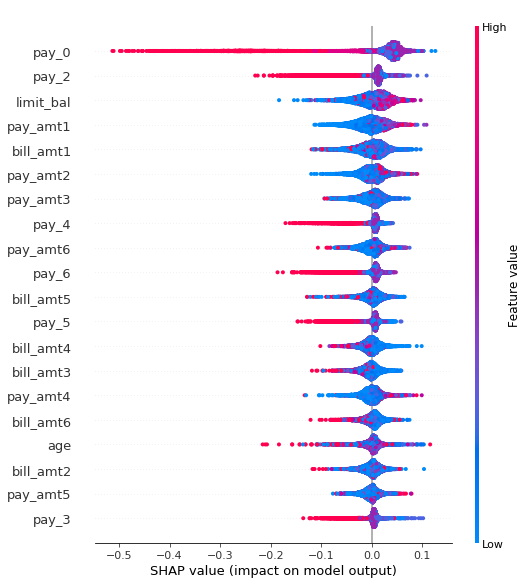

In [24]:
exp_transf = shap.TreeExplainer(model_transf_rf, X_train_transf)
shap_values_transf = exp_transf.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names)

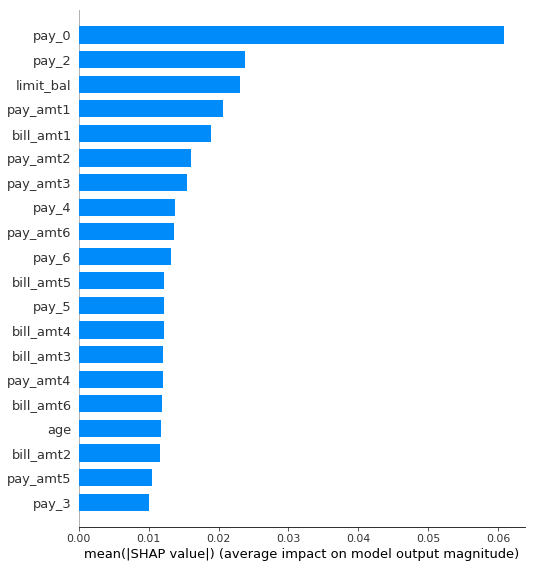

In [25]:
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names, plot_type="bar")


In [26]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,pay_0,0.060860
1,pay_2,0.023856
2,limit_bal,0.023074
3,pay_amt1,0.020700
4,bill_amt1,0.018947
5,pay_amt2,0.015993
6,pay_amt3,0.015414
7,pay_4,0.013721
8,pay_amt6,0.013654
9,pay_6,0.013126


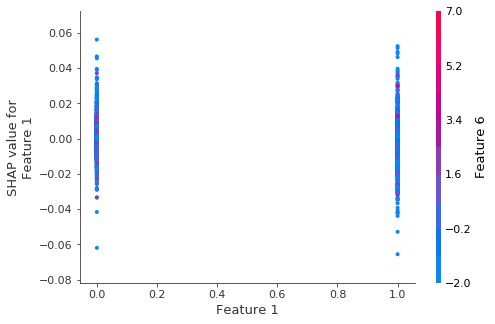

In [27]:
shap.dependence_plot(position, shap_values_transf[0], dataset_test.features)

In [28]:
df = pd.DataFrame({'shap': shap_values_transf[0][:, position], 'feat_value': dataset_test.features[:, position]})
unp_value_transf_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_rf)

Media valores SHAP classe não priveligiada:  0.0012645228064185495
Media valores SHAP classe priveligiada:  -0.002101925333025279


In [29]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

accept null hypothesis


In [0]:
lst_shape.append(('rf_transf', feat_import_transf_rf, pos_transf_rf,
                  unp_value_transf_rf, priv_value_transf_rf, priv_greater_unpriv))

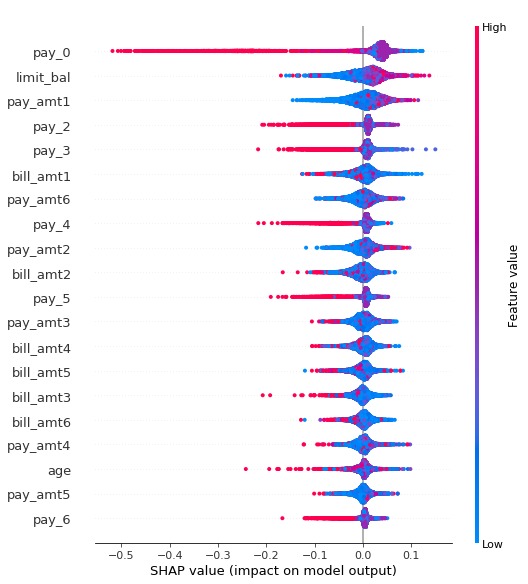

In [31]:
exp_orig = shap.TreeExplainer(model_orig_rf, X_train_orig)
shap_values_orig = exp_orig.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names)

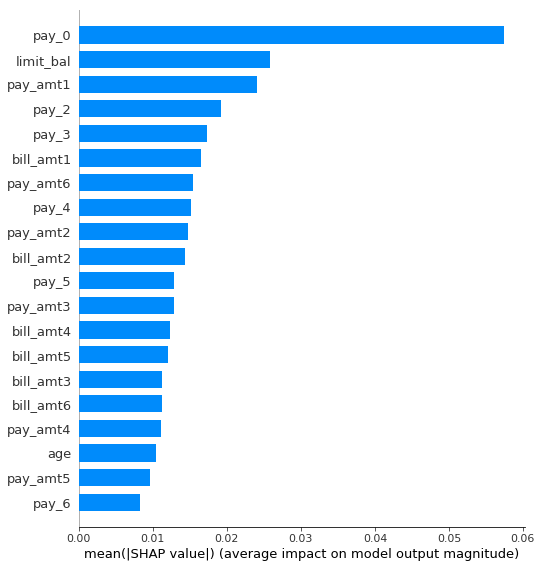

In [32]:
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [33]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,pay_0,0.057437
1,limit_bal,0.025762
2,pay_amt1,0.024082
3,pay_2,0.019188
4,pay_3,0.017362
5,bill_amt1,0.016439
6,pay_amt6,0.015486
7,pay_4,0.015113
8,pay_amt2,0.014792
9,bill_amt2,0.014393


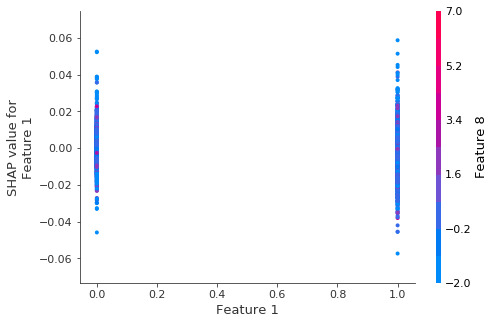

In [34]:
shap.dependence_plot(position, shap_values_orig[0], dataset_test.features)

In [35]:
df = pd.DataFrame({'shap': shap_values_orig[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_rf)

Media valores SHAP classe não priveligiada:  0.0008963695716490893
Media valores SHAP classe priveligiada:  -0.0016293864867720697


In [36]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

accept null hypothesis


In [0]:
lst_shape.append(('rf_orig', feat_import_orig_rf, pos_orig_rf, 
                  unp_value_orig_rf, priv_value_orig_rf, priv_greater_unpriv))

In [38]:
prop_feat_import_rf = (feat_import_orig_rf - feat_import_transf_rf) / feat_import_orig_rf
print('Proporção diminuição da importancia: ', prop_feat_import_rf)

Proporção diminuição da importancia:  0.1301114603458409


### Logistic Regression

Estimating transforms: 100%|██████████| 1000/1000 [00:05<00:00, 182.94it/s]


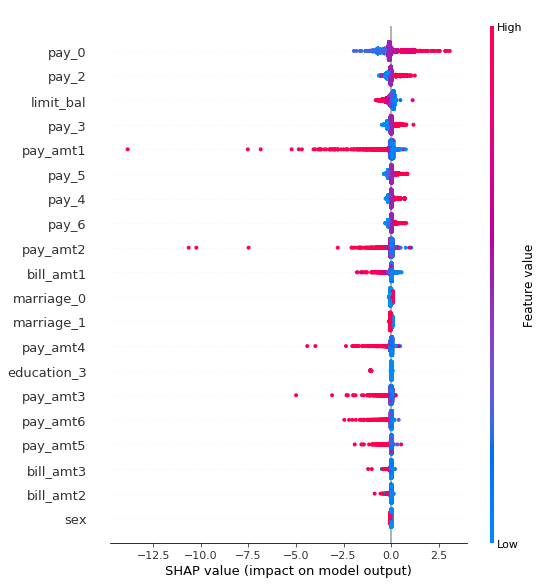

In [39]:
exp_transf_lr = shap.LinearExplainer(model_transf_lr, X_train_transf, feature_dependence="correlation")
shap_values_transf_lr = exp_transf_lr.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names)

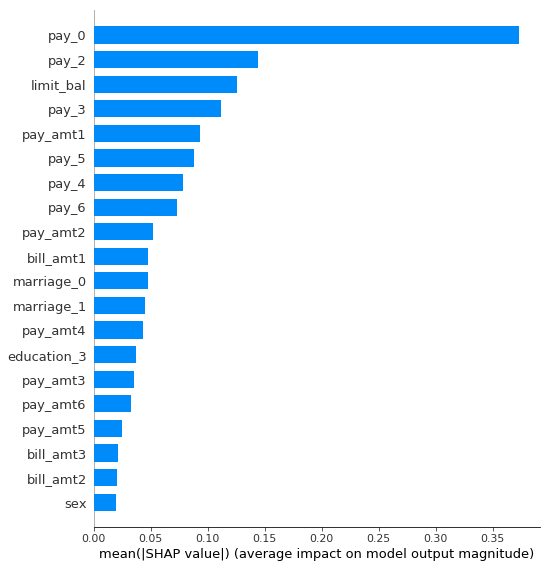

In [40]:
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names, plot_type="bar")

In [41]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,pay_0,0.373211
1,pay_2,0.143831
2,limit_bal,0.125896
3,pay_3,0.112066
4,pay_amt1,0.093194
5,pay_5,0.088355
6,pay_4,0.078228
7,pay_6,0.072606
8,pay_amt2,0.051664
9,bill_amt1,0.047380


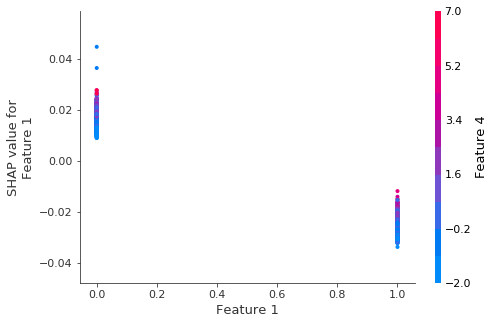

In [42]:
shap.dependence_plot(position, shap_values_transf_lr, dataset_test.features)

In [43]:
df = pd.DataFrame({'shap': shap_values_transf_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_lr)

Media valores SHAP classe não priveligiada:  0.01631903326459863
Media valores SHAP classe priveligiada:  -0.025034416216036002


In [44]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

accept null hypothesis


In [0]:
lst_shape.append(('lr_transf', feat_import_transf_lr, pos_transf_lr,
                  unp_value_transf_lr, priv_value_transf_lr, priv_greater_unpriv))

Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 358.91it/s]


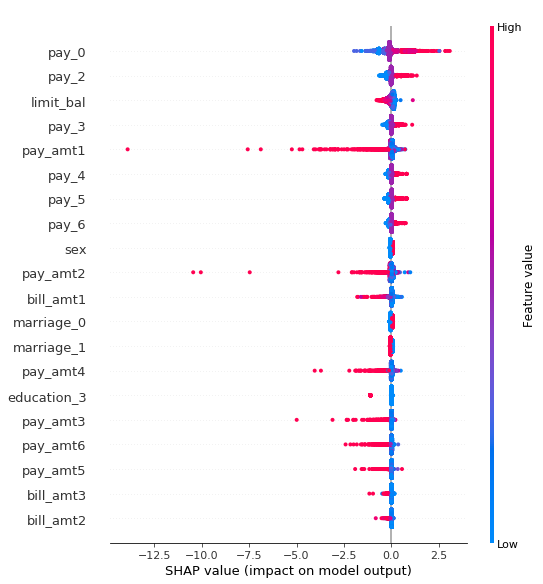

In [46]:
exp_orig_lr = shap.LinearExplainer(model_orig_lr, X_train_orig, feature_dependence="correlation")
shap_values_orig_lr = exp_orig_lr.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names)

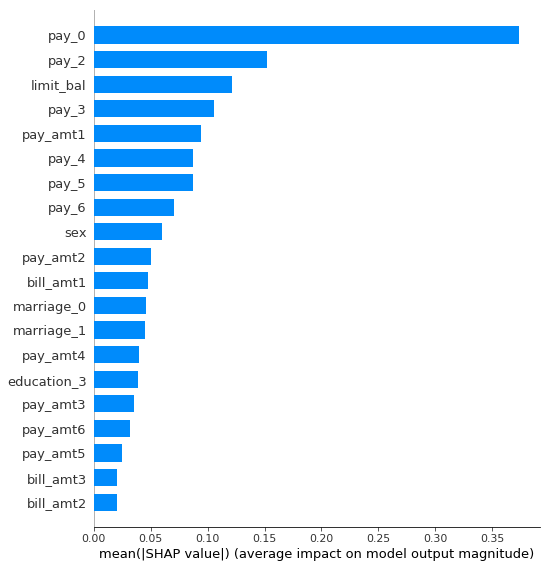

In [47]:
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [48]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,pay_0,0.373610
1,pay_2,0.152133
2,limit_bal,0.121049
3,pay_3,0.105563
4,pay_amt1,0.093928
5,pay_4,0.087011
6,pay_5,0.086978
7,pay_6,0.070018
8,sex,0.059825
9,pay_amt2,0.050358


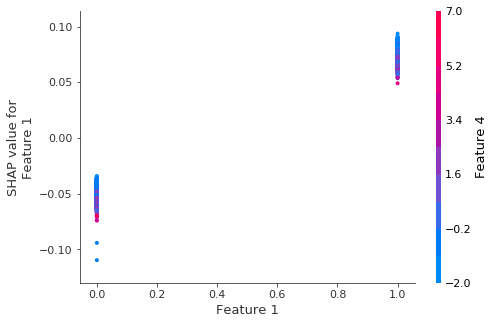

In [49]:
shap.dependence_plot(position, shap_values_orig_lr, dataset_test.features)

In [50]:
df = pd.DataFrame({'shap': shap_values_orig_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_lr)

Media valores SHAP classe não priveligiada:  -0.04964080730000839
Media valores SHAP classe priveligiada:  0.07570097103349199


In [51]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('lr_orig', feat_import_orig_lr, pos_orig_lr,
                  unp_value_orig_lr, priv_value_orig_lr, priv_greater_unpriv))

In [53]:
prop_feat_import_lr = (feat_import_orig_lr - feat_import_transf_lr) / feat_import_orig_lr
print('Proporção diminuição da importancia: ', prop_feat_import_lr)

Proporção diminuição da importancia:  0.6702889618535628


In [54]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 
                                           'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_transf,0.004256,21,0.001265,-0.002102,0,adult,0.818333,0.207545,-0.024313,0.207545,-0.012551,-0.010525,0.000649,0.106201,0.926044
1,rf_orig,0.004892,20,0.000896,-0.001629,0,adult,0.818333,0.186804,-0.022414,0.186804,-0.012841,-0.015149,0.024591,0.105754,0.927689
2,lr_transf,0.019725,19,0.016319,-0.025034,0,adult,0.823778,0.111856,-0.007442,0.111856,0.006410,0.016080,0.005461,0.106018,0.975422
3,lr_orig,0.059825,8,-0.049641,0.075701,1,adult,0.823333,0.386152,-0.030633,0.386152,-0.033856,-0.053458,-0.032057,0.106391,0.975089


In [0]:
df_final.to_csv(path + 'result/resultado_default.csv')